# Method 2 - Best Ideas Medium Focus

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Focus

focus = inst_data.groupby(['datadate', 'institution_id'])['fsym_id'].count().rename('focus').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Benchmark Weights

bm = crsp.get_crsp_market_portfolio()

# Merge Benchmark Weights onto Holdings

valid_data = valid_data.merge(bm, how='left', on=['datadate', 'fsym_id'])

# Grab Idiosyncratic Volatility

capm_var = crsp.get_capm_variance()

# Merge Idiosyncratic Volatility

valid_data = valid_data.merge(capm_var, how='left')

# Calculate Variance-Adjusted Market Tilt

valid_data['adj_target'] = (valid_data['target'] - valid_data['weight'].fillna(0)) * valid_data['capm_var']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Focus

best_ideas = best_ideas.merge(focus)
best_ideas['focus_pct'] = best_ideas.groupby('datadate')['focus'].rank(pct=True)
best_ideas = best_ideas[(best_ideas['focus_pct'] > (1 / 3)) & (best_ideas['focus_pct'] < (2 / 3))]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

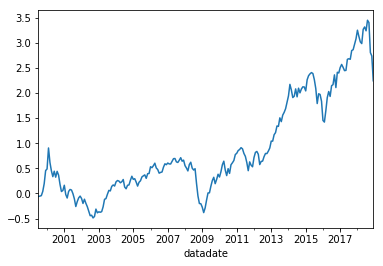

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.455557
2000-12-31   -0.271249
2001-12-31   -0.106125
2002-12-31   -0.350445
2003-12-31    0.864373
2004-12-31    0.169488
2005-12-31    0.041377
2006-12-31    0.124816
2007-12-31    0.057463
2008-12-31   -0.520779
2009-12-31    0.734347
2010-12-31    0.283530
2011-12-31   -0.137028
2012-12-31    0.244071
2013-12-31    0.475136
2014-12-31    0.109579
2015-12-31   -0.090739
2016-12-31    0.197932
2017-12-31    0.200177
2018-12-31   -0.204798
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     390.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.74e-101
Time:                        23:19:35   Log-Likelihood:                 509.23
No. Observations:                 234   AIC:                            -1008.
Df Residuals:                     229   BIC:                            -991.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0043      0.002      2.298      0.022       0.001       0.008
mktrf          1.0627      0.052     20.530      0.000       0.961       1.165
me             0.5992      0.060      9.950      0.000       0.481       0.718
ia            -0.2104      0.092     -2.299      0.022      -0.391      -0.030
roe           -0.7005      0.078     -8.942      0.000      -0.855      -0.546
==============================================================================
Omnibus:                       29.491   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.844
Skew:                           0.614   Prob(JB):                     2.26e-14
Kurtosis:                       5.222   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     371.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.32e-99
Time:                        23:19:35   Log-Likelihood:                 509.23
No. Observations:                 234   AIC:                            -1008.
Df Residuals:                     229   BIC:                            -991.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0043      0.002      1.997      0.046    8.08e-05       0.009
mktrf          1.0627      0.052     20.591      0.000       0.962       1.164
me             0.5992      0.092      6.513      0.000       0.419       0.779
ia            -0.2104      0.159     -1.323      0.186      -0.522       0.101
roe           -0.7005      0.150     -4.659      0.000      -0.995      -0.406
==============================================================================
Omnibus:                       29.491   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.844
Skew:                           0.614   Prob(JB):                     2.26e-14
Kurtosis:                       5.222   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     487.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          9.85e-111
Time:                        23:19:35   Log-Likelihood:                 509.23
No. Observations:                 234   AIC:                            -1008.
Df Residuals:                     229   BIC:                            -991.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0043      0.002      2.179      0.029       0.000       0.008
mktrf          1.0627      0.045     23.688      0.000       0.975       1.151
me             0.5992      0.098      6.102      0.000       0.407       0.792
ia            -0.2104      0.128     -1.638      0.101      -0.462       0.041
roe           -0.7005      0.159     -4.408      0.000      -1.012      -0.389
==============================================================================
Omnibus:                       29.491   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.844
Skew:                           0.614   Prob(JB):                     2.26e-14
Kurtosis:                       5.222   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     319.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          8.37e-101
Time:                        23:19:35   Log-Likelihood:                 511.98
No. Observations:                 234   AIC:                            -1012.
Df Residuals:                     228   BIC:                            -991.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.002      2.438      0.016       0.001       0.008
mktrf          1.1109      0.051     21.624      0.000       1.010       1.212
smb            0.5411      0.068      7.982      0.000       0.408       0.675
hml           -0.0212      0.080     -0.265      0.791      -0.179       0.136
rmw           -0.8016      0.090     -8.870      0.000      -0.980      -0.624
cma            0.0586      0.115      0.510      0.610      -0.168       0.285
==============================================================================
Omnibus:                       38.215   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               96.644
Skew:                           0.728   Prob(JB):                     1.03e-21
Kurtosis:                       5.791   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     167.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.52e-74
Time:                        23:19:35   Log-Likelihood:                 511.98
No. Observations:                 234   AIC:                            -1012.
Df Residuals:                     228   BIC:                            -991.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.002      2.219      0.026       0.001       0.009
mktrf          1.1109      0.061     18.338      0.000       0.992       1.230
smb            0.5411      0.057      9.501      0.000       0.429       0.653
hml           -0.0212      0.109     -0.194      0.846      -0.235       0.193
rmw           -0.8016      0.152     -5.275      0.000      -1.099      -0.504
cma            0.0586      0.159      0.369      0.712      -0.253       0.370
==============================================================================
Omnibus:                       38.215   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               96.644
Skew:                           0.728   Prob(JB):                     1.03e-21
Kurtosis:                       5.791   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     190.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.32e-79
Time:                        23:19:35   Log-Likelihood:                 511.98
No. Observations:                 234   AIC:                            -1012.
Df Residuals:                     228   BIC:                            -991.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.002      2.375      0.018       0.001       0.008
mktrf          1.1109      0.065     16.964      0.000       0.983       1.239
smb            0.5411      0.057      9.516      0.000       0.430       0.653
hml           -0.0212      0.083     -0.255      0.799      -0.184       0.142
rmw           -0.8016      0.146     -5.480      0.000      -1.088      -0.515
cma            0.0586      0.134      0.438      0.661      -0.204       0.321
==============================================================================
Omnibus:                       38.215   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               96.644
Skew:                           0.728   Prob(JB):                     1.03e-21
Kurtosis:                       5.791   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     303.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.52e-90
Time:                        23:19:35   Log-Likelihood:                 484.15
No. Observations:                 234   AIC:                            -958.3
Df Residuals:                     229   BIC:                            -941.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.002      0.746      0.456      -0.003       0.006
mktrf          1.2357      0.053     23.293      0.000       1.131       1.340
smb            0.8479      0.066     12.804      0.000       0.717       0.978
hml           -0.1509      0.066     -2.294      0.023      -0.281      -0.021
umd           -0.1650      0.043     -3.822      0.000      -0.250      -0.080
==============================================================================
Omnibus:                       27.379   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.980
Skew:                           0.560   Prob(JB):                     9.45e-14
Kurtosis:                       5.213   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     196.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.57e-73
Time:                        23:19:35   Log-Likelihood:                 484.15
No. Observations:                 234   AIC:                            -958.3
Df Residuals:                     229   BIC:                            -941.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.002      0.754      0.451      -0.002       0.006
mktrf          1.2357      0.060     20.747      0.000       1.119       1.352
smb            0.8479      0.108      7.850      0.000       0.636       1.060
hml           -0.1509      0.102     -1.482      0.138      -0.350       0.049
umd           -0.1650      0.081     -2.029      0.042      -0.324      -0.006
==============================================================================
Omnibus:                       27.379   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.980
Skew:                           0.560   Prob(JB):                     9.45e-14
Kurtosis:                       5.213   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     192.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.98e-72
Time:                        23:19:35   Log-Likelihood:                 484.15
No. Observations:                 234   AIC:                            -958.3
Df Residuals:                     229   BIC:                            -941.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.002      0.887      0.375      -0.002       0.005
mktrf          1.2357      0.057     21.589      0.000       1.124       1.348
smb            0.8479      0.099      8.583      0.000       0.654       1.042
hml           -0.1509      0.088     -1.709      0.087      -0.324       0.022
umd           -0.1650      0.081     -2.038      0.042      -0.324      -0.006
==============================================================================
Omnibus:                       27.379   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.980
Skew:                           0.560   Prob(JB):                     9.45e-14
Kurtosis:                       5.213   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     179.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.06e-48
Time:                        23:19:35   Log-Likelihood:                 235.86
No. Observations:                 120   AIC:                            -461.7
Df Residuals:                     115   BIC:                            -447.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0060      0.003      1.817      0.072      -0.001       0.013
mktrf          1.0860      0.089     12.168      0.000       0.909       1.263
me             0.6203      0.088      7.037      0.000       0.446       0.795
ia            -0.2239      0.138     -1.622      0.108      -0.497       0.050
roe           -0.6484      0.122     -5.308      0.000      -0.890      -0.406
==============================================================================
Omnibus:                       10.281   Durbin-Watson:                   2.104
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               12.478
Skew:                           0.507   Prob(JB):                      0.00195
Kurtosis:                       4.211   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     188.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.76e-49
Time:                        23:19:35   Log-Likelihood:                 235.86
No. Observations:                 120   AIC:                            -461.7
Df Residuals:                     115   BIC:                            -447.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0060      0.004      1.553      0.120      -0.002       0.014
mktrf          1.0860      0.081     13.375      0.000       0.927       1.245
me             0.6203      0.122      5.103      0.000       0.382       0.859
ia            -0.2239      0.223     -1.004      0.315      -0.661       0.213
roe           -0.6484      0.214     -3.026      0.002      -1.068      -0.228
==============================================================================
Omnibus:                       10.281   Durbin-Watson:                   2.104
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               12.478
Skew:                           0.507   Prob(JB):                      0.00195
Kurtosis:                       4.211   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     317.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.62e-61
Time:                        23:19:35   Log-Likelihood:                 235.86
No. Observations:                 120   AIC:                            -461.7
Df Residuals:                     115   BIC:                            -447.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0060      0.003      1.745      0.081      -0.001       0.013
mktrf          1.0860      0.065     16.766      0.000       0.959       1.213
me             0.6203      0.131      4.735      0.000       0.364       0.877
ia            -0.2239      0.185     -1.210      0.226      -0.587       0.139
roe           -0.6484      0.226     -2.866      0.004      -1.092      -0.205
==============================================================================
Omnibus:                       10.281   Durbin-Watson:                   2.104
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               12.478
Skew:                           0.507   Prob(JB):                      0.00195
Kurtosis:                       4.211   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     166.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.03e-50
Time:                        23:19:35   Log-Likelihood:                 244.27
No. Observations:                 120   AIC:                            -476.5
Df Residuals:                     114   BIC:                            -459.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0088      0.003      2.755      0.007       0.002       0.015
mktrf          1.1398      0.088     12.934      0.000       0.965       1.314
smb            0.5188      0.100      5.198      0.000       0.321       0.717
hml           -0.0426      0.122     -0.348      0.728      -0.285       0.200
rmw           -0.8121      0.144     -5.630      0.000      -1.098      -0.526
cma            0.1225      0.158      0.775      0.440      -0.190       0.436
==============================================================================
Omnibus:                       16.351   Durbin-Watson:                   2.110
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.493
Skew:                           0.617   Prob(JB):                     1.07e-06
Kurtosis:                       4.995   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     120.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.31e-44
Time:                        23:19:35   Log-Likelihood:                 244.27
No. Observations:                 120   AIC:                            -476.5
Df Residuals:                     114   BIC:                            -459.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0088      0.003      2.818      0.005       0.003       0.015
mktrf          1.1398      0.109     10.420      0.000       0.925       1.354
smb            0.5188      0.079      6.580      0.000       0.364       0.673
hml           -0.0426      0.167     -0.255      0.799      -0.370       0.285
rmw           -0.8121      0.225     -3.615      0.000      -1.252      -0.372
cma            0.1225      0.188      0.651      0.515      -0.246       0.491
==============================================================================
Omnibus:                       16.351   Durbin-Watson:                   2.110
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.493
Skew:                           0.617   Prob(JB):                     1.07e-06
Kurtosis:                       4.995   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     180.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.00e-52
Time:                        23:19:35   Log-Likelihood:                 244.27
No. Observations:                 120   AIC:                            -476.5
Df Residuals:                     114   BIC:                            -459.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0088      0.003      3.284      0.001       0.004       0.014
mktrf          1.1398      0.110     10.337      0.000       0.924       1.356
smb            0.5188      0.079      6.563      0.000       0.364       0.674
hml           -0.0426      0.138     -0.308      0.758      -0.314       0.229
rmw           -0.8121      0.223     -3.643      0.000      -1.249      -0.375
cma            0.1225      0.144      0.848      0.396      -0.161       0.406
==============================================================================
Omnibus:                       16.351   Durbin-Watson:                   2.110
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.493
Skew:                           0.617   Prob(JB):                     1.07e-06
Kurtosis:                       4.995   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     159.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.56e-46
Time:                        23:19:35   Log-Likelihood:                 230.00
No. Observations:                 120   AIC:                            -450.0
Df Residuals:                     115   BIC:                            -436.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0048      0.003      1.410      0.161      -0.002       0.012
mktrf          1.3146      0.083     15.924      0.000       1.151       1.478
smb            0.8462      0.094      9.002      0.000       0.660       1.032
hml           -0.1886      0.094     -2.004      0.047      -0.375      -0.002
umd           -0.1337      0.058     -2.304      0.023      -0.249      -0.019
==============================================================================
Omnibus:                        9.347   Durbin-Watson:                   2.187
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               15.186
Skew:                           0.322   Prob(JB):                     0.000504
Kurtosis:                       4.620   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     151.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.56e-45
Time:                        23:19:35   Log-Likelihood:                 230.00
No. Observations:                 120   AIC:                            -450.0
Df Residuals:                     115   BIC:                            -436.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0048      0.003      1.516      0.129      -0.001       0.011
mktrf          1.3146      0.084     15.739      0.000       1.151       1.478
smb            0.8462      0.131      6.477      0.000       0.590       1.102
hml           -0.1886      0.127     -1.480      0.139      -0.438       0.061
umd           -0.1337      0.093     -1.442      0.149      -0.315       0.048
==============================================================================
Omnibus:                        9.347   Durbin-Watson:                   2.187
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               15.186
Skew:                           0.322   Prob(JB):                     0.000504
Kurtosis:                       4.620   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     230.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.20e-54
Time:                        23:19:35   Log-Likelihood:                 230.00
No. Observations:                 120   AIC:                            -450.0
Df Residuals:                     115   BIC:                            -436.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0048      0.002      1.994      0.046    8.15e-05       0.010
mktrf          1.3146      0.066     19.888      0.000       1.185       1.444
smb            0.8462      0.120      7.029      0.000       0.610       1.082
hml           -0.1886      0.110     -1.720      0.085      -0.404       0.026
umd           -0.1337      0.085     -1.568      0.117      -0.301       0.033
==============================================================================
Omnibus:                        9.347   Durbin-Watson:                   2.187
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               15.186
Skew:                           0.322   Prob(JB):                     0.000504
Kurtosis:                       4.620   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     257.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.58e-54
Time:                        23:19:35   Log-Likelihood:                 297.19
No. Observations:                 114   AIC:                            -584.4
Df Residuals:                     109   BIC:                            -570.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.002      1.336      0.184      -0.001       0.006
mktrf          1.0809      0.054     20.142      0.000       0.975       1.187
me             0.4958      0.083      5.983      0.000       0.332       0.660
ia            -0.2348      0.115     -2.043      0.043      -0.463      -0.007
roe           -0.8450      0.101     -8.368      0.000      -1.045      -0.645
==============================================================================
Omnibus:                        1.019   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.601   Jarque-Bera (JB):                0.779
Skew:                           0.201   Prob(JB):                        0.677
Kurtosis:                       3.050   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     371.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.59e-62
Time:                        23:19:35   Log-Likelihood:                 297.19
No. Observations:                 114   AIC:                            -584.4
Df Residuals:                     109   BIC:                            -570.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      1.750      0.080      -0.000       0.005
mktrf          1.0809      0.050     21.775      0.000       0.984       1.178
me             0.4958      0.048     10.329      0.000       0.402       0.590
ia            -0.2348      0.099     -2.362      0.018      -0.430      -0.040
roe           -0.8450      0.106     -8.009      0.000      -1.052      -0.638
==============================================================================
Omnibus:                        1.019   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.601   Jarque-Bera (JB):                0.779
Skew:                           0.201   Prob(JB):                        0.677
Kurtosis:                       3.050   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     615.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.98e-74
Time:                        23:19:35   Log-Likelihood:                 297.19
No. Observations:                 114   AIC:                            -584.4
Df Residuals:                     109   BIC:                            -570.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      1.768      0.077      -0.000       0.005
mktrf          1.0809      0.044     24.460      0.000       0.994       1.168
me             0.4958      0.040     12.265      0.000       0.417       0.575
ia            -0.2348      0.099     -2.375      0.018      -0.429      -0.041
roe           -0.8450      0.085     -9.898      0.000      -1.012      -0.678
==============================================================================
Omnibus:                        1.019   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.601   Jarque-Bera (JB):                0.779
Skew:                           0.201   Prob(JB):                        0.677
Kurtosis:                       3.050   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     151.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.65e-47
Time:                        23:19:35   Log-Likelihood:                 281.98
No. Observations:                 114   AIC:                            -552.0
Df Residuals:                     108   BIC:                            -535.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.002      0.195      0.846      -0.004       0.005
mktrf          1.1245      0.059     19.140      0.000       1.008       1.241
smb            0.5107      0.095      5.354      0.000       0.322       0.700
hml            0.0426      0.122      0.351      0.727      -0.198       0.284
rmw           -0.7930      0.149     -5.324      0.000      -1.088      -0.498
cma           -0.1500      0.189     -0.793      0.429      -0.525       0.225
==============================================================================
Omnibus:                        0.412   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.814   Jarque-Bera (JB):                0.545
Skew:                           0.125   Prob(JB):                        0.761
Kurtosis:                       2.770   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     109.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.36e-40
Time:                        23:19:35   Log-Likelihood:                 281.98
No. Observations:                 114   AIC:                            -552.0
Df Residuals:                     108   BIC:                            -535.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.002      0.215      0.830      -0.003       0.004
mktrf          1.1245      0.063     17.771      0.000       1.001       1.249
smb            0.5107      0.071      7.194      0.000       0.372       0.650
hml            0.0426      0.121      0.352      0.725      -0.195       0.280
rmw           -0.7930      0.199     -3.982      0.000      -1.183      -0.403
cma           -0.1500      0.162     -0.928      0.353      -0.467       0.167
==============================================================================
Omnibus:                        0.412   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.814   Jarque-Bera (JB):                0.545
Skew:                           0.125   Prob(JB):                        0.761
Kurtosis:                       2.770   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     170.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.44e-49
Time:                        23:19:35   Log-Likelihood:                 281.98
No. Observations:                 114   AIC:                            -552.0
Df Residuals:                     108   BIC:                            -535.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.002      0.236      0.814      -0.003       0.004
mktrf          1.1245      0.062     18.207      0.000       1.003       1.246
smb            0.5107      0.067      7.675      0.000       0.380       0.641
hml            0.0426      0.124      0.344      0.731      -0.200       0.286
rmw           -0.7930      0.186     -4.271      0.000      -1.157      -0.429
cma           -0.1500      0.170     -0.880      0.379      -0.484       0.184
==============================================================================
Omnibus:                        0.412   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.814   Jarque-Bera (JB):                0.545
Skew:                           0.125   Prob(JB):                        0.761
Kurtosis:                       2.770   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     151.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.42e-43
Time:                        23:19:35   Log-Likelihood:                 270.74
No. Observations:                 114   AIC:                            -531.5
Df Residuals:                     109   BIC:                            -517.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.002     -0.294      0.769      -0.005       0.004
mktrf          1.1625      0.064     18.127      0.000       1.035       1.290
smb            0.6955      0.100      6.955      0.000       0.497       0.894
hml            0.0211      0.103      0.205      0.838      -0.183       0.225
umd           -0.1996      0.078     -2.569      0.012      -0.354      -0.046
==============================================================================
Omnibus:                       11.175   Durbin-Watson:                   1.795
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               12.666
Skew:                           0.603   Prob(JB):                      0.00178
Kurtosis:                       4.101   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     173.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.38e-46
Time:                        23:19:35   Log-Likelihood:                 270.74
No. Observations:                 114   AIC:                            -531.5
Df Residuals:                     109   BIC:                            -517.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.002     -0.382      0.702      -0.004       0.003
mktrf          1.1625      0.064     18.255      0.000       1.038       1.287
smb            0.6955      0.085      8.156      0.000       0.528       0.863
hml            0.0211      0.149      0.142      0.887      -0.270       0.312
umd           -0.1996      0.094     -2.126      0.033      -0.384      -0.016
==============================================================================
Omnibus:                       11.175   Durbin-Watson:                   1.795
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               12.666
Skew:                           0.603   Prob(JB):                      0.00178
Kurtosis:                       4.101   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     219.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.88e-51
Time:                        23:19:35   Log-Likelihood:                 270.74
No. Observations:                 114   AIC:                            -531.5
Df Residuals:                     109   BIC:                            -517.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.002     -0.419      0.675      -0.004       0.002
mktrf          1.1625      0.060     19.383      0.000       1.045       1.280
smb            0.6955      0.074      9.408      0.000       0.551       0.840
hml            0.0211      0.156      0.135      0.892      -0.285       0.327
umd           -0.1996      0.094     -2.115      0.034      -0.385      -0.015
==============================================================================
Omnibus:                       11.175   Durbin-Watson:                   1.795
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               12.666
Skew:                           0.603   Prob(JB):                      0.00178
Kurtosis:                       4.101   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""